# Demonstration of the evomap Package

Replication file for the paper

Matthe, Maximilian (2023), "evomap: A Python Package for Dynamic Mapping". 

Python environment: evomap-package

# Setup

In [24]:
import pandas as pd
import numpy as np
import os

PATH_HOME = os.path.dirname(os.getcwd())
PATH_OUT = os.path.join(PATH_HOME, 'gen')

'c:\\Users\\MPMATTHE\\Dropbox (Privat)\\Promotion\\Research-Projects\\Projects\\02-Single-Author\\Code'

In [2]:
from evomap.datasets import load_tnic_snapshot_small

data = load_tnic_snapshot_small()

In [3]:
title_fontdict = {'size': 12, 'family': 'Arial'}
label_fontdict = {'size': 10, 'family': 'Arial'}

# Load Sample Data

In [4]:
S = data['matrix']
labels = data['labels']

In [5]:
np.round(S, 2)

array([[0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.06, 0.04, 0.  , 0.07],
       [0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ],
       [0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.03, 0.  , 0.  , 0.  ],
       [0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.06, 0.  , 0.  , 0.03, 0.01, 0.05, 0.  , 0.1 , 0.  , 0.03],
       [0.04, 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.  , 0.03],
       [0.  , 0.08, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.03, 0.  , 0.  ]])

In [6]:
from evomap.preprocessing import sim2dist
D = sim2dist(S, transformation = 'mirror')

# Section 1: Static MDS Demonstration

In [7]:
from evomap.mapping import MDS
Y = MDS(mds_type = 'interval', init = 'cmds').fit_transform(D)

[MDS] Iteration 17: gradient norm vanished. Final cost: 0.20


In [8]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map

fig, ax = plt.subplots(1,2, figsize = (14,7))
draw_map(
    Y, 
    labels = labels, 
    ax = ax[0])

ax[0].set_title('A: Non-Metric MDS Map \n', fontdict = title_fontdict)
ax[0].set_xlabel('Dimension 1', fontdict = label_fontdict)
ax[0].set_ylabel('Dimension 2', fontdict = label_fontdict)

Text(0, 0.5, 'Dimension 2')

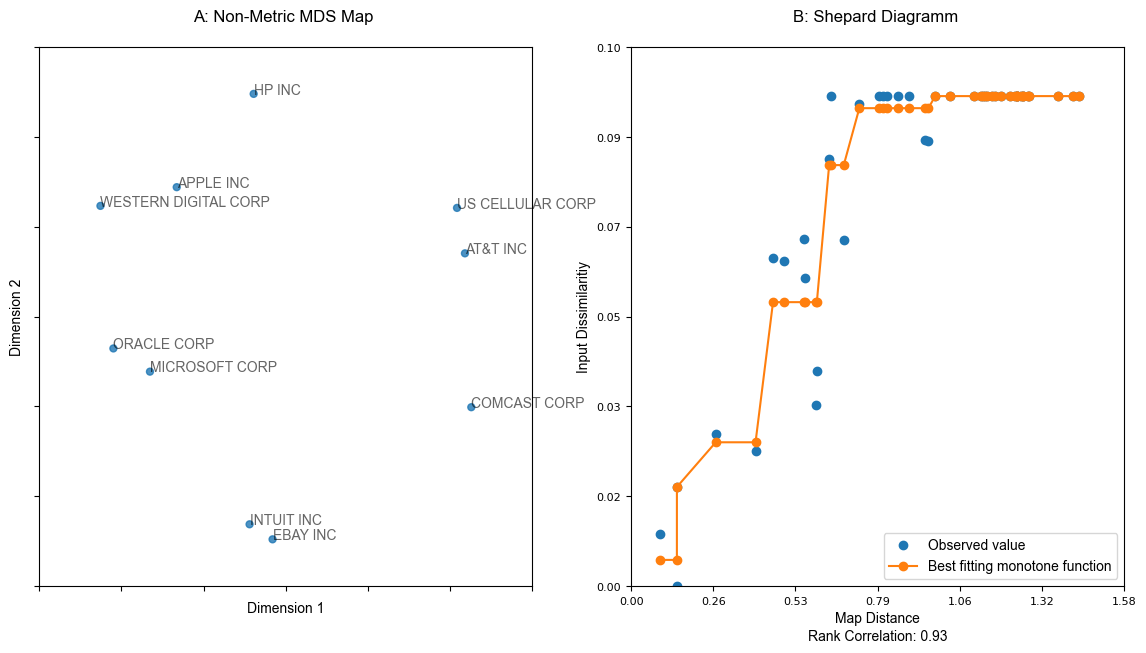

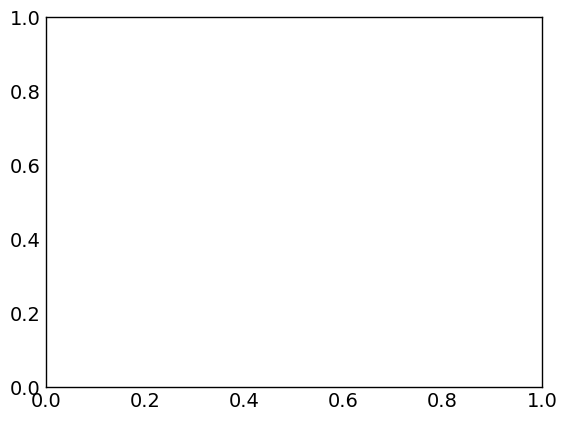

In [9]:
def draw_shepard_diagramm(Y, D, ax = None):
    
    from sklearn.isotonic import IsotonicRegression
    from scipy.spatial.distance import cdist
    from scipy.stats import spearmanr

    ir = IsotonicRegression()
    distances = cdist(Y, Y, metric = 'euclidean')
    distances_flat = distances[np.tril_indices(len(distances),-1)]
    disparities_flat = D[np.tril_indices(len(D),-1)]        

    disp_hat = ir.fit_transform(distances_flat, disparities_flat)
    df = pd.DataFrame({'disp': disparities_flat, 'dist': distances_flat, 'disp_hat' : disp_hat})
    df = df.sort_values('dist')

    from matplotlib.ticker import FuncFormatter

    def format_tick_labels(x, pos):
        return '{0:.2f}'.format(x)

    if ax is None:
        fig, ax = plt.subplots(figsize = (5,5))

    ax.plot(df['dist'], df['disp'], "C0.", markersize = 12)
    ax.plot(df['dist'], df['disp_hat'], "C1.-", markersize = 12)
    ax.set_xlabel('Map Distance', fontdict = label_fontdict)
    ax.set_ylabel('Input Dissimilaritiy', fontdict= label_fontdict)
    x_min = 0
    x_max = df['dist'].max() * 1.1
    y_min = 0
    y_max = df['disp_hat'].max() * 1.1
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    y_ticks = np.linspace(y_min, y_max, 7)
    x_ticks = np.linspace(x_min, x_max, 7)

    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.tick_params(axis = 'both', labelsize = 8)
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))

    ax.text(0.5, -0.1, 
           "Rank Correlation: {0:.2f}".format(spearmanr(df['dist'], df['disp_hat'])[0]), 
           ha = 'center', 
           transform = ax.transAxes, 
           fontdict = label_fontdict)
    
    plt.grid(False)

    return ax

draw_shepard_diagramm(Y,D, ax[1])
ax[1].set_title('B: Shepard Diagramm \n', fontdict= title_fontdict)
ax[1].legend(['Observed value', 'Best fitting monotone function'], loc = 4, prop = label_fontdict)
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_statc.PNG'), dpi = 300)

In [10]:
from evomap.datasets import load_tnic_sample_small
data = load_tnic_sample_small()
data = data.query('name1 in @labels').query('name2 in @labels')

In [11]:
data = data[['year', 'name1', 'name2', 'score']]
data = data.sort_values(['year', 'name1'])
data.head(10)

,year,name1,name2,score
4794,1998,APPLE INC,HP INC,0.0691
4850,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657
4882,1998,APPLE INC,MICROSOFT CORP,0.0601
4902,1998,APPLE INC,ORACLE CORP,0.0355
35618,1998,AT&T INC,COMCAST CORP,0.0321
35697,1998,AT&T INC,US CELLULAR CORP,0.0761
10594,1998,COMCAST CORP,AT&T INC,0.0321
10643,1998,COMCAST CORP,US CELLULAR CORP,0.0122
19028,1998,HP INC,APPLE INC,0.0691
19152,1998,HP INC,MICROSOFT CORP,0.0087


In [12]:
periods = data.year.unique()

In [13]:
from evomap.preprocessing import edgelist2matrix
matrix, label = edgelist2matrix(data, score_var= 'score', id_var_i= 'name1', id_var_j= 'name2')

In [14]:
def edgelist2matrices(data, score_var, id_var_i, id_var_j, time_var):
    periods = data[time_var].unique()
    matrices = []
    for period in periods:
        data_t = data[data[time_var] == period]
        mat_t, labels = edgelist2matrix(data_t, 
                                        score_var = score_var,
                                         id_var_i = id_var_i, 
                                         id_var_j = id_var_j)
        matrices.append(mat_t)
    return matrices, label

S_t, lables = edgelist2matrices(data, score_var= 'score', id_var_i = 'name1', id_var_j='name2', time_var='year')

In [15]:
D_t = []
for S in S_t:
    D_t.append(sim2dist(S, transformation = 'mirror'))

In [16]:
Y_0 = MDS(
    mds_type= 'ordinal',
    init = 'cmds', 
    verbose = 2).fit_transform(D_t[0])


[MDS] Initialization 1/1
[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 18: gradient norm vanished. Final cost: 0.13


In [17]:
Y_1 = MDS(
    mds_type= 'ordinal',
    init = 'cmds', 
    verbose = 2).fit_transform(D_t[2])


[MDS] Initialization 1/1
[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 29: gradient norm vanished. Final cost: 0.15


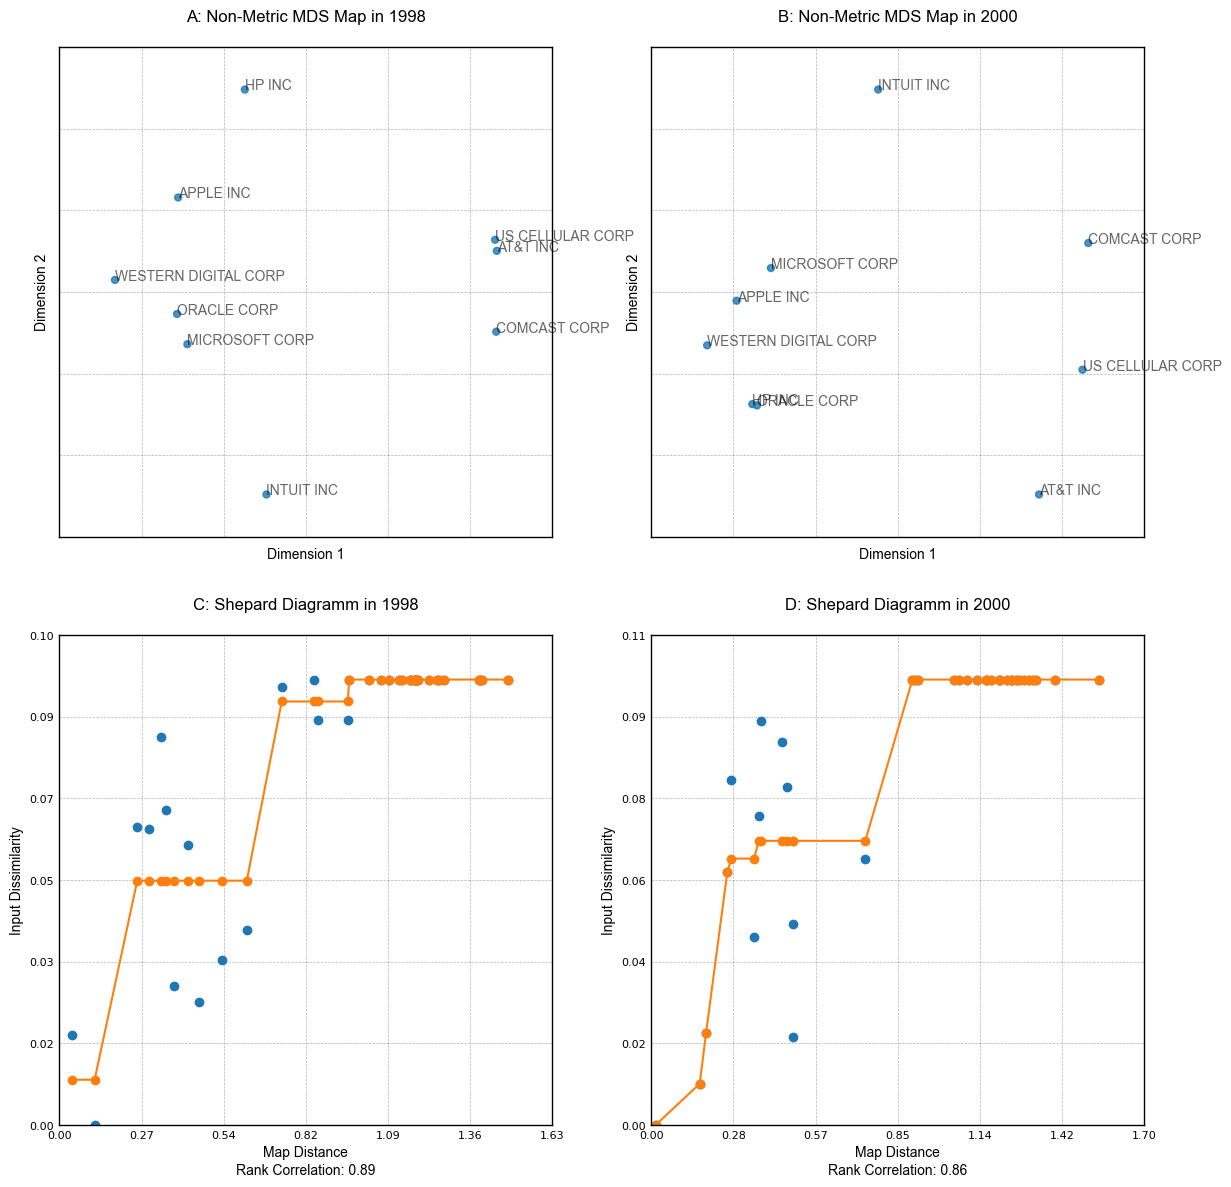

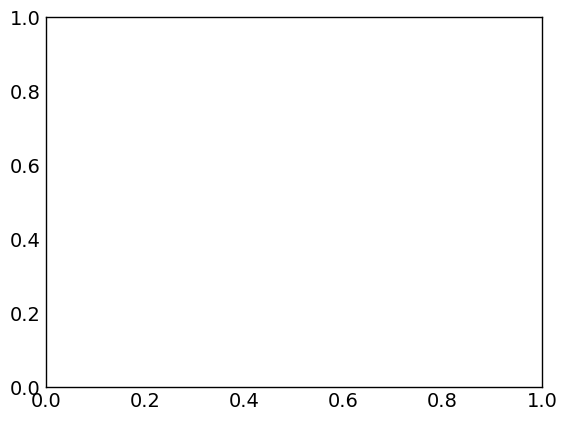

In [21]:
fig, ax = plt.subplots(2,2,figsize = (14,14))
draw_map(Y_0, labels = label, ax = ax[0,0])
ax[0,0].set_title('A: Non-Metric MDS Map in {0}\n'.format(periods[0]), fontdict = title_fontdict)
ax[0,0].set_xlabel('Dimension 1', fontdict = label_fontdict)
ax[0,0].set_ylabel('Dimension 2', fontdict = label_fontdict)

draw_map(Y_1, labels = label, ax = ax[0,1])
ax[0,1].set_title('B: Non-Metric MDS Map in {0}\n'.format(periods[2]), fontdict = title_fontdict)
ax[0,1].set_xlabel('Dimension 1', fontdict = label_fontdict)
ax[0,1].set_ylabel('Dimension 2', fontdict = label_fontdict)

draw_shepard_diagramm(Y_0, D_t[0], ax[1,0])
ax[1,0].set_title('C: Shepard Diagramm in {0}\n'.format(periods[0]), fontdict = title_fontdict)
ax[1,0].set_xlabel('Map Distance', fontdict = label_fontdict)
ax[1,0].set_ylabel('Input Dissimilarity', fontdict = label_fontdict)

draw_shepard_diagramm(Y_1, D_t[2], ax[1,1])
ax[1,1].set_title('D: Shepard Diagramm in {0}\n'.format(periods[2]), fontdict = title_fontdict)
ax[1,1].set_xlabel('Map Distance', fontdict = label_fontdict)
ax[1,1].set_ylabel('Input Dissimilarity', fontdict = label_fontdict)
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_dynamic.PNG'), dpi = 300)
fig

In [ ]:
fig

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (14,7))
draw_shepard_diagramm(Y_0, D_t[0], ax[0])
draw_shepard_diagramm(Y_1, D_t[2], ax[1])
fig
